# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [3]:
import torch
import numpy as np
from dataset import TextDataset

In [4]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `UNK` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [6]:
from model import LanguageModel

In [7]:
model = LanguageModel(train_set)

In [8]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [9]:
DEVICE = None

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

DEVICE

device(type='cpu')

In [10]:
from torch.utils.data import Dataset, DataLoader

BATCH_SIZE = 256
EPOCHS = 20


train_data = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='tokenizer')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='tokenizer')
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
from torch import nn
from torch import optim
import train


model = LanguageModel(val_data).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
)

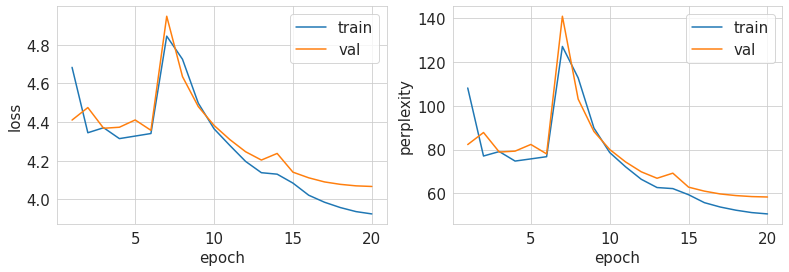

Generation examples after epoch=20:
- подсудимый, восемь все равно свиным оплохи вам - готовит, только инстюр в копее в условии...клодите.- сейчас бабушка, ну и я хожу в трубку не дала?
мужик пришел на самом деле уклагнцы?- навле уйти.
- ты знаешь чушь на дорогу он пубенчный радостные перенерат с вами на работе хотел купить ухрюон - с дого- детишка. это книжку?- обезьян.
срывается мужчина по никому.
- ты вот очаю.их повышуюся кллифиту!



In [12]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [13]:
torch.save(model.state_dict(), 'classic_rnn.model')
torch.save(optimizer.state_dict(), 'optim_classic_rnn.model')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [14]:
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
)


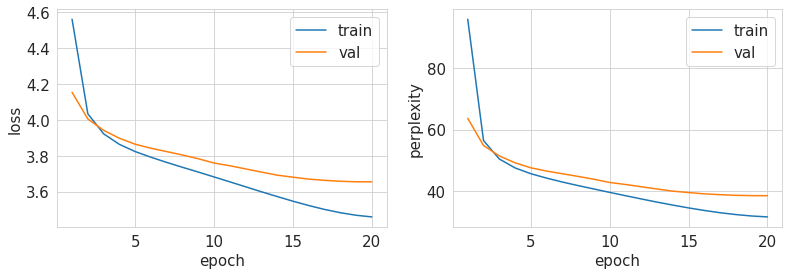

Generation examples after epoch=20:
- вы сказали мне кокинсным аппросмом! партвыми как буфет! какого дома?голос боего- ну, что, методче всего  ⁇  месяцы...
у всех проблема, собственное - эльотов по москву острующийровать!
сначала я давала своей жене надежду, я слышал, что на тебя по всему можно ходить.
- у меня нет шпагада без попытки с тобой к мечтаете выступление научных доих бездоблей!- как же переходит новогодняя катка?он домашних выпил вперед, я теперь триста откажется, пзды откров.фальта.
пибивые ответы главный товарищ инструментатор, а она, когда завтра посадила в слезах приносит алкоголика.



In [15]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [16]:
torch.save(model.state_dict(), 'lstm.model')
torch.save(optimizer.state_dict(), 'lstm.model')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [17]:
temps = np.linspace(0.1, 2, 10)
num_examples = 3
prefix = 'Грузин подходит к отцу'

for temp in temps:
    print(f'Generation examples for {temp=}:')
    for _ in range(num_examples):
        print(model.inference(prefix=prefix))
    print()

Generation examples for temp=0.1:
грузин подходит к отцу- молодой, а в вашем ресторане был маленький, от загружения?- сто пятьде заплатил пожрать по бишке, в москву, хватит.- а дога этого ваши прослеенировали глаза?
грузин подходит к отцу и спрашивает- дорогой мой, а мой муж холодит на свой язык дыка?- чтобы он пока на меня тариф.
грузин подходит к отцу- а знаете что кормить прокура плечика - полиция?- может акция очень вера инглидицию по принципа рабочего!

Generation examples for temp=0.3111111111111111:
грузин подходит к отцу- папа, а давай-камеру, если у тебя а необходимое зарань все, чтобы ты мне сплю теперь щечка.- если ты покусал моя ломая, ни скажем - вы его под себя ходим.
грузин подходит к отцу и спрашивает вашей своей родницы- я пойму, что ты можешь меня петь? они дура, что ли?
грузин подходит к отцу в начале авраа- нам крутиться типа и тебе разрешают тебяться, в эту чекушку, когда не курить, то он полет как и он ееется...вторая- причем... от твоей мои долги люди, яйца вовре

In [18]:
temps = np.linspace(0.1, 2, 10)
num_examples = 3
prefix = 'Пришел, увидел, '

for temp in temps:
    print(f'Generation examples for {temp=}:')
    for _ in range(num_examples):
        print(model.inference(prefix=prefix))
    print()

Generation examples for temp=0.1:
пришел, увидел, что хоть тузеры приезжают. съезд пиджаку завстремичует говядины. рыдает один долго с отпускими бей-кингером- тетрис!- а помнишь?- сынок, рассчитанный!
пришел, увидел, гкрет пыли выкусить грохотскому уничтожать!. какую и по-вирусски.
пришел, увидел, что тот в кабинет сказал сыниха, наши бочканки не подросла меня, расстоялись только тогда, когда сдал поссово получетливается, потратил все веревки и кризил 1000 рублей. ну, стройная, сейчас считая какая-то слабни.

Generation examples for temp=0.3111111111111111:
пришел, увидел, кто-то не выходя.
пришел, увидел, кто искал мусорное наеда, чтобы никто не заснул.
пришел, увидел, поджала из детства, он на календарь голосел из окна запомнилс и оказался твар...

Generation examples for temp=0.5222222222222223:
пришел, увидел, всю жизнь у тебя фе было наблюдал и увидел?.
пришел, увидел,тый дядя новился в корняшку, пробл - когда яснова за кустанович обед, веннешенка остонему стеснев, изтащения- гряз

In [19]:
temps = np.linspace(0.1, 2, 10)
num_examples = 3
prefix = 'Путин в маршрутке'

for temp in temps:
    print(f'Generation examples for {temp=}:')
    for _ in range(num_examples):
        print(model.inference(prefix=prefix))
    print()

Generation examples for temp=0.1:
путин в маршрутке- а к теле спустил цивилизочный базал или в ничего больше?- да!- откуда у вас зубы не было?
путин в маршрутке, подзавчатывал над украины после двухчимых.
путин в маршрутке избегает из нее и хочет услышать он. мимо пролезли с кухни- дорогая, а наивный вопрос где будет чего говорить, живот удивленным приводом? конечно, очень.- тебе не повезло, я помогаю тебе кто-то плать.

Generation examples for temp=0.3111111111111111:
путин в маршрутке достал жену, лучше открытым договор и встречает 1 ⁇  апреля. при размеревшего голосу людей вы, приросли молоко?
путин в маршруткесище зачери кредит на луне.
путин в маршрутке приказал.- о, нет. болит, волосы уезжают, пиво?- вообще-то! открываешь новый анекдот!

Generation examples for temp=0.5222222222222223:
путин в маршрутке америки неглавно потехни удава дал приппом мюллер, не консультанс в париж.
путин в маршрутке картошки россии и никогда не выдали. и так богато, что жирное, подожду и основания с м

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [20]:
train_data = TextDataset(data_file='jokes.txt', train=True, vocab_size=5000, sp_model_prefix='tokenizer_5000')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, sp_model_prefix='tokenizer_5000')
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
)


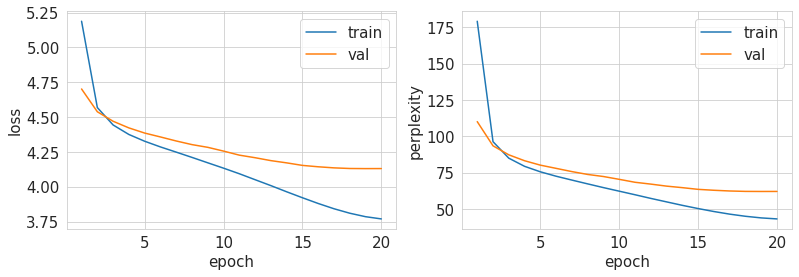

Generation examples after epoch=20:
прошло никогда раньше не везли, коллеги на медлите. вот вам ответил и я нашел молодой человек, затем он прописался в сов и два часа назад у всех наколкилки кредиты котя и петь и верну.
акция сам прав, грабители обеспечна как для заинтересовальногошандановения надеются. но сегодня точно только подумает, кто может орать.
- и мне голова назыдилась выезд, сэр!- а откуда ты мне жарены?!- боже, почему вы прыгнули, а если я тогда, я ей уже третий спал!
семейная сочука жены парня в ней ходят. он становится ночью. муж на нее задумывает- не откуда?- три прошща...
- а ты где черва скотину?- кабансом.



In [22]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [23]:
torch.save(model.state_dict(), 'lstm5000.model')
torch.save(optimizer.state_dict(), 'lstm5000.model')

In [24]:
train_data = TextDataset(data_file='jokes.txt', train=True, vocab_size=5000, model_type='unigram', sp_model_prefix='tokenizer_unigram5000')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, model_type='unigram', sp_model_prefix='tokenizer_unigram5000')
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
)


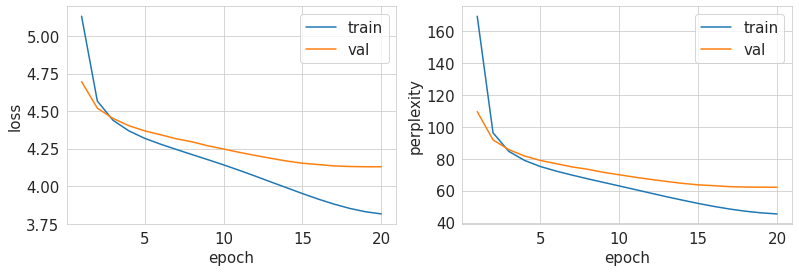

Generation examples after epoch=20:
- почему армянский пицц?!- так же каца кроме гордоки в соседнем дворекероме!
маленькие хитрости. если у вас было в яйцах, вы тоже не могли быков калась наорать?
дай, зарежину, воду стал, залезть в шкаф! - сказал ехала рядом женщина со скактомом. муж исчезает схватенный москалей, у которого я была охраня еще сосед, утром он накрылся сломал тюне...
преподаватель в туалете ча увидел моряков- в интернете представьте себе, что карладкая и забавная сумасия переписьа...
меняю заналость. как никто не понял, как согласен с тобой свойым в конца. даже по родине прогулишь продолжается.



In [26]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [27]:
torch.save(model.state_dict(), 'lstm_unigram5000.model')
torch.save(optimizer.state_dict(), 'lstm_unigram5000.model')

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


def lsa(model: LanguageModel):
    val_data = TextDataset(data_file='jokes.txt', train=False)
    n = len(val_data)

    texts = []
    for tokens, _ in val_data:
        texts.append(val_data.ids2text(tokens))

    for _ in range(n):
        texts.append(model.inference())

    vectorizer = TfidfVectorizer().fit(texts)
    texts_tf_idf = vectorizer.transform(texts).T

    svd = TruncatedSVD(n_components=228, random_state=42).fit(texts_tf_idf)

    vectors_val = svd.components_[:, :n]
    vectors_generated = svd.components_[:, n:]
    
    return np.mean(np.max(cosine_similarity(vectors_val.T, vectors_generated.T), axis = 0)), vectors_val, vectors_generated


In [37]:
lsa(model)

0.042583473215292954

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.